<a href="https://colab.research.google.com/github/marcoramosw/Penumonia-Detection-CNN/blob/master/Pneumonia_Detection_CNN_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from PIL import Image

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import os


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#os.environ['KAGGLE_USERNAME'] = "marcoalexandreramos" 
#os.environ['KAGGLE_KEY'] = "52663cb89b7aedaccd8da94b19921f6f"
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

#Loading the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook. The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as grayscale to RGB, random scaling, cropping, and flipping. This will help the network generalize leading to better performance. The input data must be resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this no scaling or rotation transformations will be applied, but the images still need to be resized and then croped to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [ ]:
data_dir = '/content/drive/My Drive/Data Bases/chest_xray'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [ ]:
# Defining transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.Lambda(lambda x: x.convert('RGB')),#transform grayscale ro rgb
                                          transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Lambda(lambda x: x.convert('RGB')),
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Lambda(lambda x: x.convert('RGB')),
                                         transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

#  Loading the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# Using the image datasets and the transforms, defining the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True, num_workers=4)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

In [ ]:
print(len(training_dataset))
print(len(validation_dataset))
print(len(testing_dataset))

5226
16
632


# Label/Category mapping


In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

find_classes(train_dir)

(['.DS_Store', 'NORMAL', 'PNEUMONIA'],
 {'.DS_Store': 0, 'NORMAL': 1, 'PNEUMONIA': 2})

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I will be using one of the pretrained models from `torchvision.models` to get the image features and then build and train a new feed-forward classifier using those features.

In [ ]:
# Building and training the network using Transfer Learning
model = models.vgg16(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
#model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freezing pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Building custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 2)),#2 classes (pneumonia, normal)
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [ ]:
#Total Parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

117,487,426 total parameters.
102,772,738 training parameters.


In [ ]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for images, labels in iter(validateloader):

        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

#callback = Callback(model, config, early_stop_patience=2, outdir="model")




In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [ ]:
# Trainning the classifier


#from workspace_utils import active_session -> this can be used so that the session remains on and not disconnect


def train_classifier():


    epochs = 15
    steps = 0
    print_every = 40
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
     
    
    model.to(device)

    for e in range(epochs):
        
        model.train()
    
        running_loss = 0
    
        for images, labels in iter(train_loader):
        
            steps += 1
        
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                
                model.eval()
                
                # Turning off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validate_loader, criterion)
            
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                        "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                        "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                        "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
                running_loss = 0

                model.train()      
train_classifier()                    

Epoch: 1/15..  Training Loss: 1.705..  Validation Loss: 0.144..  Validation Accuracy: 0.938
Epoch: 1/15..  Training Loss: 0.290..  Validation Loss: 0.220..  Validation Accuracy: 0.938
Epoch: 2/15..  Training Loss: 0.247..  Validation Loss: 0.155..  Validation Accuracy: 1.000
Epoch: 2/15..  Training Loss: 0.270..  Validation Loss: 0.252..  Validation Accuracy: 0.938
Epoch: 3/15..  Training Loss: 0.213..  Validation Loss: 0.315..  Validation Accuracy: 0.875
Epoch: 3/15..  Training Loss: 0.243..  Validation Loss: 0.333..  Validation Accuracy: 0.812
Epoch: 4/15..  Training Loss: 0.193..  Validation Loss: 0.169..  Validation Accuracy: 0.938
Epoch: 4/15..  Training Loss: 0.247..  Validation Loss: 0.146..  Validation Accuracy: 0.938
Epoch: 5/15..  Training Loss: 0.174..  Validation Loss: 0.206..  Validation Accuracy: 0.938
Epoch: 5/15..  Training Loss: 0.230..  Validation Loss: 0.141..  Validation Accuracy: 0.938
Epoch: 6/15..  Training Loss: 0.169..  Validation Loss: 0.129..  Validation Accu

In [ ]:
#callback.reset_early_stop()
#callback.early_stop_patience = 5

# Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. I will run the test images through the network and measure the accuracy, the same way I did validation. 

In [ ]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to(device), labels.to(device)
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.890625


# Saving the checkpoint

Now that the network is trained, it needs to be saved so it can be loaded later to make predictions. Other things such as the mapping of classes to indices are going to be saved also, which can be obtained from one of the image datasets: `image_datasets['train'].class_to_idx`. 

attaching this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

For the model to be completely rebuilt later, for inference, more info needs to be saved in the checkpoint: 
- number of epochs. 
- optimizer state, `optimizer.state_dict`.

In [ ]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)    

# Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [ ]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                          ('relu', nn.ReLU()),
                                          ('drop', nn.Dropout(p=0.5)),
                                          ('fc2', nn.Linear(4096, 2)),#2 classes (pneumonia, normal)
                                          ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model


In [ ]:
model = load_checkpoint('/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
if torch.cuda.is_available():
    model.cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Inference for classification

Writing a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the Chest X-Ray. 

Writing a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 

First the input image needs to be processed in the same manner it was for training, so that it can be used in the network. 


## Image Preprocessing

I'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as an input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array, which can be obtained from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Dimensions must be reordered using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
#from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path).convert('RGB') #.convert('RGB') for grayscale to rgb
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
  
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image



Checking work done untill now, the function below converts a PyTorch tensor and displays it in the notebook. If `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

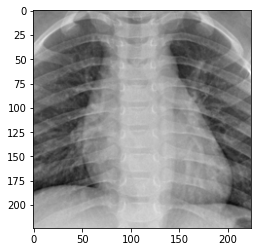

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('/content/drive/My Drive/Data Bases/chest_xray/test/NORMAL/NORMAL2-IM-0332-0001.jpeg')
imshow(image)

# Class Prediction

Once the images are in the correct format, it's time to write a function to make predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes, is this case we just have 2 (Normal and Pneumonia). I'll calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. The indices need to be converted to the actual class labels using `class_to_idx` which was added to the model, it can also be done from an `ImageFolder` used to load the data ([see here](#Save-the-checkpoint)). 

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.


In [ ]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk=2): #just 2 classes
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

predict_image_path='/content/drive/My Drive/Data Bases/chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg'

probs, classes = predict(predict_image_path, model)   
print(probs)
print(classes)

[0.9324209094047546, 0.0675790011882782]
['PNEUMONIA', 'NORMAL']


# Confusion Matrix

# Sanity Checking

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Using `matplotlib` to plot the probabilities for the 2 classes as a bar graph, along with the input image. 

Introduce the image path to be predicted in "predict_image_path" object above


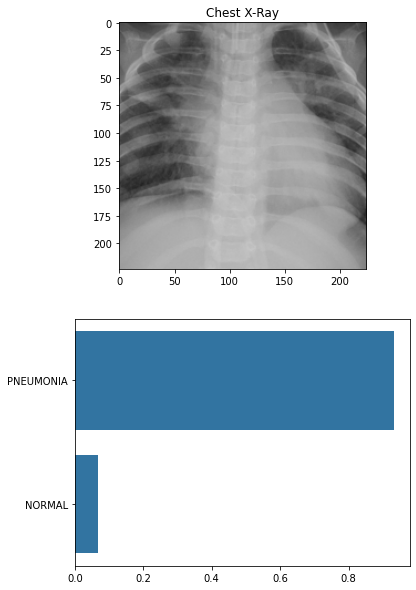

In [ ]:
# Display an image along with the probability of being normal or pneumonia

# Plot Chest X-Ray input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

image = process_image(predict_image_path)

imshow(image, plot_1, title='Chest X-Ray');

# Plot the probabilities for the pneumonia and normal as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=probs, y=classes, color=sb.color_palette()[0]);

plt.show()